 <div style="text-align:center;">
   <span style="color:green; font-size:2em; font-weight:bold;">Exploratory Data Analysis (EDA)</span><br><br>
</div>


# <span style="color:green; text-align:center;">Introduction</span>

Dans cette partie, nous nous intéressons à la visualisation des données ainsi qu'à l'analyse descriptive des données de **"final_data"** obtenue suite au nettoyage des bases de données initiales du fichier "Préparation_données.ipynb".

Dans cette partie nous allons nous interesser à la visualisation de nos données ainsi qu'à l'analyse descriptive. Pour les taux de chômage et de croissance, nous allons se concentrer uniquement sur les observations de la période s'étallant de **2019** à **2023**. Nous voulons à partir de cela visualiser les niveaux moyens de chomage et de croissance économique pour les cinq dernières années.
L'objectif ici est de mettre en pratique les méthodes vues en cours.

**Précision :**

Pour la représentation graphique des séries temporelles, la période considérée est celle s'étallant de **1994** à **2023**.

-La visualisation se fera par le biais de deux applications Dash.
-L'analyse descriptive portera sur une série temporelle particulière.

In [ ]:
# Import des packages
from importlib import reload
import declarations as d
reload(d)

In [ ]:
# Importation  de la base de données
df = d.pd.read_csv("../final_data.csv")

In [ ]:
# Visualisation
df.head()

In [ ]:
# Telécharger le shapefile
world = d.gpd.read_file(d.gpd.datasets.get_path('naturalearth_lowres'))
world=world.rename(columns={'name': 'COUNTRY'})
world.head()

In [ ]:
# Sélectionner certaines colonnes
columns_to_keep = ['geometry', 'COUNTRY', 'continent']
world = world[columns_to_keep]

# Mettre les noms des colonnes en abréviation
world['COUNTRY'] = d.correct_country_name(world['COUNTRY'])

# Fusionner les deux DataFrames
world_df = d.pd.merge(world, df, how='inner', on=['COUNTRY'])

In [ ]:
# Visualisation
world_df.head()

# <span style="color:green; text-align:center;">II- VISUALISATION DES DONNEES</span>

In [ ]:
# Plot
world_df.plot(color='lightgrey')

Deux applications seront créer pour la visualition des données:
<div style="margin-left: 20px;">
-La premiere sera instantanné et à l'échelle mondiale. <br>
-La seconde c'est la représentation de la série temporelle par continent.
    </div>

In [ ]:
# Créer un Dash app
app1 = d.dash.Dash(__name__)

# Définir le layout 
app1.layout = d.html.Div([
    # Sélecteur d'année
    d.dcc.Dropdown(
        id='year-dropdown',
        options=[{'label': year, 'value': year} for year in sorted(world_df['YEAR'].unique())],
        value=world_df['YEAR'].min(),  #valeur par defaut de l'année
        multi=False,
    ),
    # Sélecteur de variables
    d.dcc.Dropdown(
        id='variable-dropdown',
        options=[
            {'label': 'Unemployment Rate', 'value': 'Unemployment_rate'},
            {'label': 'GDP growth Rate', 'value': 'GDP_rate'},
            {'label': 'Life expentancy', 'value': 'life_expentancy'},
            {'label': 'Population growth rate', 'value': 'pop_growth_rate'}
          
        ],
        value='Unemployment_rate',  # valeur par defaut de la variable representée
        multi=False,
    ),
    d.dcc.Graph(id='choropleth-map'),
])

# Définir un callback  pour mettre à jour la carte sur l'année selectionnée 
@app1.callback(
    d.Output('choropleth-map', 'figure'),
    [d.Input('year-dropdown', 'value'),
     d.Input('variable-dropdown', 'value')]
)
def update_map(selected_year, selected_variable):
    subset_gdf = world_df[world_df['YEAR'] == selected_year]
    subset_gdf.index = subset_gdf['COUNTRY']
    fig = d.px.choropleth(
        subset_gdf,
        geojson=subset_gdf.geometry,
        locations=subset_gdf.index,
        color=selected_variable,
        projection="natural earth",
        title=f'{selected_variable} in {selected_year}',
    )
    fig.update_geos(fitbounds="locations", visible=True)
    return fig

# Executer l'application
if __name__ == '__main__':
    app1.run_server(debug=True, port=8050)


In [ ]:
df=world_df.copy()
app2 = d.dash.Dash(__name__)

# Créer votre graphique initial
fig = d.px.line(df, x='YEAR', y=["Unemployment_rate"], color='COUNTRY')

# Créer la mise en page de votre application Dash
app2.layout = d.html.Div([
    # Sélecteur de continents
    d.dcc.Dropdown(
        id='continent-selector',
        options=[
            {'label': continent, 'value': continent}
            for continent in df['continent'].unique()
        ],
        multi=True,
        value=df['continent'].unique()  # Sélectionner tous les continents par défaut
    ),
    # Sélecteur de variables
    d.dcc.Dropdown(
        id='variable-dropdown',
        options=[
            {'label': 'Unemployment Rate', 'value': 'Unemployment_rate'},
            {'label': 'GDP growth Rate', 'value': 'GDP_rate'},
            {'label': 'Life expentancy', 'value': 'life_expentancy'},
            {'label': 'Population growth rate', 'value': 'pop_growth_rate'}
          
        ],
        value='Unemployment_rate',  # Valeur par defaut de la variable representée
        multi=False,
    ),
    
    # Graphique
    d.dcc.Graph(
        id='line-chart',
        figure=fig
    )
])

# Définisser la logique de la mise à jour du graphique en fonction de la sélection du sélecteur
@app2.callback(
    d.Output('line-chart', 'figure'),
    [d.Input('variable-dropdown', 'value'),
     d.Input('continent-selector', 'value')]
)
def update_graph2(selected_variable, selected_continents):
    filtered_df = df[df['continent'].isin(selected_continents)]
    fig = d.px.line(filtered_df, x='YEAR', y=[selected_variable], color='COUNTRY',
                   labels={'YEAR': 'Année', selected_variable : f"{selected_variable}"})
    return fig


# Exécuter l'application Dash
if __name__ == '__main__':
    app2.run_server(debug=True, port=8051)


In [ ]:
# Group by Country, sélectionner uniquement les 4 colonnes et faire la moyenne dans chaque groupe
df_group = df.groupby('COUNTRY')[
    ['Unemployment_rate', 'GDP_rate', 'life_expentancy', 'pop_growth_rate']
    ].mean().reset_index()

In [ ]:
# Visualisation
df_group.head()

In [ ]:
app3 = d.dash.Dash(__name__)

# Créer votre graphique initial
fig = d.px.bar(df_group, x='COUNTRY', y='Unemployment_rate', color='COUNTRY',
             labels={'COUNTRY': 'Pays', 'Unemployment_rate': 'Taux de chômage moyen'},
             #title='Taux de chômage moyen par pays sur la période 2019-2023',
             template='plotly_dark')

# Créer la mise en page de votre application Dash
app3.layout = d.html.Div([
    
    # Sélecteur de variables
    d.dcc.Dropdown(
        id='variable-dropdown',
        options=[
            {'label': 'Unemployment Rate', 'value': 'Unemployment_rate'},
            {'label': 'GDP growth Rate', 'value': 'GDP_rate'},
            {'label': 'Life expentancy', 'value': 'life_expentancy'},
            {'label': 'Population growth rate', 'value': 'pop_growth_rate'}
          
        ],
        value='Unemployment_rate',  # valeur par defaut de la variable representée
        multi=False,
    ),
    
    # Graphique
    d.dcc.Graph(
        id='bar',
        figure=fig
    )
])

# Définisser la logique de la mise à jour du graphique en fonction de la sélection du sélecteur
@app3.callback(
    d.Output('bar', 'figure'),
    [d.Input('variable-dropdown', 'value')]
)
def update_graph3(selected_variable):
    #fig = px.line(filtered_df, x='YEAR', y=["Unemployment_rate"], color='COUNTRY')
    fig = d.px.bar(df, x='COUNTRY', y=[selected_variable], color='COUNTRY',
                   labels={'COUNTRY': 'Pays', selected_variable: selected_variable},
                   template='plotly_dark')
    return fig


# Exécuter l'application Dash
if __name__ == '__main__':
    app3.run_server(debug=True, port=8052)


In [ ]:
# Créer un graphique interactif avec Plotly Express
fig = d.px.bar(df_group, x='COUNTRY', y='Unemployment_rate', color='COUNTRY',
             labels={'COUNTRY': 'Pays', 'Unemployment_rate': 'Taux de chômage moyen'},
             title='Taux de chômage moyen par pays sur la période 2019-2023',
             template='plotly_dark')

# Afficher le graphique interactif
fig.show()

# <span style="color:green; text-align:center;">II- Analyse descriptive </span>

In [ ]:
final_data= d.pd.read_csv('C:/Projet-Python/Projet-Python/final_data.csv')

In [ ]:
final_data.head()

## <span style="color:green; text-align:center;">II-1.Série temporelle taux de chômage </span>

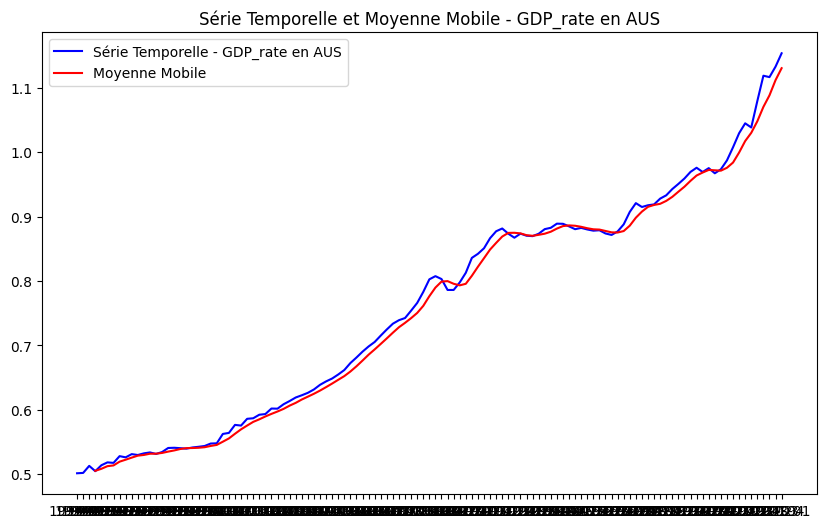

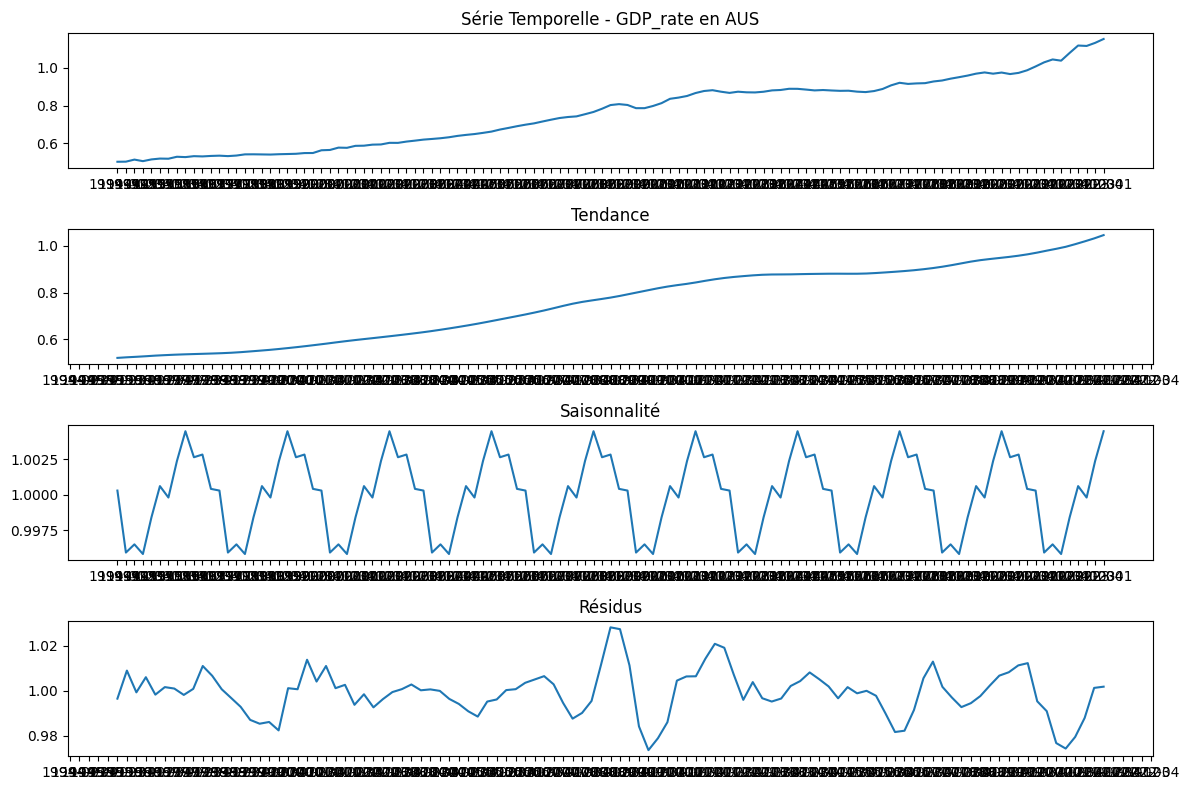

Test de Dickey-Fuller Augmenté:
Statistique de test = 1.7208618023939806
Valeur critique = {'1%': -3.4885349695076844, '5%': -2.887019521656941, '10%': -2.5803597920604915}


In [139]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

def analyse_serie_temporelle_pays(indicateur, pays):
    # Utilisation de la fonction pivot pour remodeler le dataframe
    df = final_data.pivot(index=['YEAR'], columns='COUNTRY', values=[indicateur])
    df['YEAR'] = pd.to_datetime(df.index)
    
    # Sélectionner la série temporelle du pays spécifique
    serie_temporelle = df[indicateur, pays].dropna()
    
    # Moyenne mobile d'ordre 4
    rolling_mean = serie_temporelle.rolling(window=4).mean()

    # Visualisation de la série temporelle et de la moyenne mobile dans le même plot
    plt.figure(figsize=(10, 6))
    plt.plot(serie_temporelle, label=f'Série Temporelle - {indicateur} en {pays}', color='blue')
    plt.plot(rolling_mean, label='Moyenne Mobile', color='red')
    plt.title(f'Série Temporelle et Moyenne Mobile - {indicateur} en {pays}')
    plt.legend()
    plt.show()

    # Décomposition saisonnière
    decomposition = seasonal_decompose(serie_temporelle, model='multiplicative', period=12)

    # Visualisation des composants décomposés
    plt.figure(figsize=(12, 8))

    # Série Temporelle
    plt.subplot(4, 1, 1)
    plt.plot(serie_temporelle)
    plt.title(f'Série Temporelle - {indicateur} en {pays}')

    # Tendance
    plt.subplot(4, 1, 2)
    plt.plot(decomposition.trend)
    plt.title('Tendance')

    # Saisonnalité
    plt.subplot(4, 1, 3)
    plt.plot(decomposition.seasonal)
    plt.title('Saisonnalité')

    # Résidus
    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid)
    plt.title('Résidus')

    plt.tight_layout()
    plt.show()

    # Test de stationnarité (Augmented Dickey-Fuller)
    result = adfuller(serie_temporelle)
    print(f'Test de Dickey-Fuller Augmenté:\nStatistique de test = {result[0]}\nValeur critique = {result[4]}')

# Utilisation de la fonction avec le DataFrame 'final_data', le pays 'AUS', et la variable 'Unemployment_rate'
analyse_serie_temporelle_pays('GDP_rate', 'AUS')
